### Learning Physical Informed Neural Networks with JAX

For this tutorial, I will be using a simple PDE model so we can check the results against the analytical solution.

Consider the one-dimension heat equation:

$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}  
$$

With $u(x,t)$ the temperature, $\alpha$ the diffusion coefficient, $x$ the space and $t$ the time.

The problem has boundary conditions:

$$
u(0,t) = 0 \\
u(L,t) = 0 \\
$$

And initial condition:

$$
u(x,0) = \sin \left (\frac{\pi x}{L}\right)
$$

The <u>solution</u> for this problem is:

$$
u(x,t) = \sin \left (\frac{\pi x}{L}\right) e^{-\alpha \left (\frac{\pi}{L}\right)^2t}
$$

In [1782]:
# Include jacfwd and jacrev

In [1783]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

#from jax.example_libraries import optimizers
import optax
import optimistix as optx


In [1784]:
class Rod():
    ## Class representing the rod

    def __init__(self, alpha, L):
        self.alpha = alpha
        self.L = L

    def solution_u(self, x, t):
        return np.sin(np.pi * x / self.L)*np.exp(-self.alpha * (np.pi/self.L)**2 * t)
    
    def solve(self, T, d = 0.01):
        self.T = T
        x_values = np.linspace(0, self.L, int(self.L/d))
        t_values = np.linspace(0, T, int(T/d))

        self.x_array, self.t_array = np.meshgrid(x_values, t_values)
        
        self.solution = self.solution_u(self.x_array, self.t_array)
    
    def plot(self):
        if not hasattr(self, 'solution'):
            print("Solve first")
        else:

            #plt.figure(figsize=(10, 8))
            #plt.contourf(self.x_array, self.t_array, self.solution, levels=15, cmap='hot')
            plt.imshow(self.solution.T, extent=[0, self.T, 0, self.L,], aspect='auto', origin='lower', cmap='jet')
            plt.colorbar(label='Temperature')
            plt.xlabel('Time')
            plt.ylabel('Space')
            plt.title('Heat Equation | Analytical Solution')
            plt.show()



In [1785]:
alpha = 0.5
L = 5
rod = Rod(alpha, L)


In [1827]:
T = 5
d=0.005
rod.solve(T, d=d)

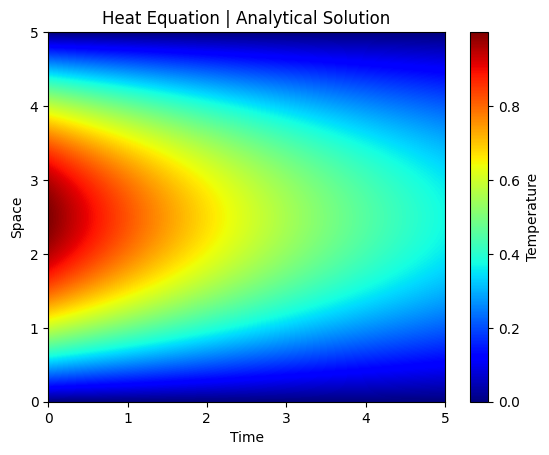

In [1828]:
rod.plot()

Now is time to Neural Networks. In this tutorial I will use JAX and Equinox. Jax is a library developed by Google for high-performance numerical computing, our main interest is its automatic differential capability. Skimming over, automatic differential, or autodiff, is a efficity way to compute function's (including NN) numerical derivatives. JAX offer a numpy-like sintax, autodiff, and vectorized operations. Equinox is a library building using JAX to facilitate Neural Network implementations.



Let's define our Multilayer Perceptron class

In [1829]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        x = self.layers[-1](x)
        return x


And create one, with 2 inputs $x$ and $t$, 3 hidden layers with 3 nodes in each and one output $u(x,t)$.


In [1830]:
# Initialize the model with multiple hidden layers
model_key = jax.random.PRNGKey(1)

layers_size = 3
n_layers = 3

model = MLP(model_key, input_dim=2, hidden_dims=layers_size, n_layers=n_layers, output_dim=1)


In [1831]:
model_key = jax.random.PRNGKey(1)

model = eqx.nn.MLP(in_size=2, out_size=1, width_size=50, depth=2,
                    activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)

Feeding an input to test

In [1832]:
input = jnp.array([1., 2.])
model(input)

Array([-0.24852957], dtype=float32)

If we want to pass a batch of inputs, we must use the jax.vmap function to vectorize our model.

In [1833]:
# Example batch input
batch_input_data = jnp.array([
    [1.0, 2.0],
    [3.0, 4.0],
    [5.0, 6.0]
])
batch_output = jax.vmap(model)(batch_input_data)
batch_output

Array([[-0.2485295 ],
       [-0.23257104],
       [-0.22687607]], dtype=float32)

We got a result. Is this the solution for the heat equation? Unless we are extremly lucky, no.

What is our idea here. There exist a function $u(x,t)$ fullfiling the PDE, initial and boundary conditions stated in the beggining. If a function fullfils that, it IS the solution. What if instead of finding THE solution, we find an approximation that attend all the stated conditions close enough?

Well, Neural Networks are universal function approximator, which mean we can approximate any function with any degree of accuracy. So the idea is to use the Multilayer Perceptron as an approximation, fullfiling the conditions with a certain degree of accuracy.


"But how do we train that if we do not have a sample of input-output?" you may ask

In [1834]:
batch_input_data

Array([[1., 2.],
       [3., 4.],
       [5., 6.]], dtype=float32)

In [1835]:
jax.vmap(jax.hessian(model))(batch_input_data)

Array([[[[-0.00019602, -0.00181036],
         [-0.00181036,  0.00073096]]],


       [[[-0.00107167, -0.00138506],
         [-0.00138506,  0.00119803]]],


       [[[-0.00010352, -0.00116238],
         [-0.00116238,  0.00145835]]]], dtype=float32)

In [1927]:
import numpy as np
import jax
import jax.numpy as jnp
import equinox as eqx
import optax

# Define model
model_key = jax.random.PRNGKey(5)
model = eqx.nn.MLP(in_size=2, out_size=1, width_size=10, depth=1,
                   activation=jax.nn.sigmoid, use_final_bias=False, key=model_key)



x_values = jnp.linspace(0, L, 25)
t_values = jnp.linspace(0, T, 25)
x_grid, t_grid = jnp.meshgrid(x_values, t_values, indexing='ij')
batch_input_data = jnp.stack([x_grid.ravel(), t_grid.ravel()], axis=-1)

# Define loss functions
def pde_loss(params, model_state, x, alpha):
    model = eqx.combine(params, model_state)
    du_dt = jax.vmap(jax.grad(lambda x: model(x)[0]))(x)[:, 1]  # First derivative wrt to the second input
    
    # Compute the second derivative using jax.hessian is more intuive and flexible, but more expensive
    #du2_d2t = jax.vmap(jax.hessian(lambda x: model(x)[0]))(x)[:, 0, 0]
    d2u_dx2 = jax.vmap(jax.grad(lambda x: jax.grad(lambda x: model(x)[0])(x)[0]))(x)[:, 0]
    return jnp.mean((du_dt - alpha * d2u_dx2) ** 2)

def bc_loss(params, model_state, L, t_array):
    model = eqx.combine(params, model_state)
    zeros_array = jnp.zeros_like(t_array)
    L_array = jnp.full_like(t_array, L)
    input_0 = jnp.stack([zeros_array, t_array], axis=1)
    input_L = jnp.stack([L_array, t_array], axis=1)

    return jnp.mean(jax.vmap(model)(input_0) ** 2 + jax.vmap(model)(input_L) ** 2)

def ic_loss(params, model_state, L):
    model = eqx.combine(params, model_state)
    xs = jnp.linspace(0,L,25)
    zeros_array = jnp.zeros_like(xs)
    input = jnp.stack([xs, zeros_array], axis=1)

    return jnp.mean((jax.vmap(model)(input).squeeze() - jnp.sin((jnp.pi/L) * xs))**2)


    

def loss(params, model_state, x, L, t_array, alpha):
    return 2*pde_loss(params, model_state, x, alpha) + 2*bc_loss(params, model_state, L, t_array) + ic_loss(params, model_state, L)

# Time array
t_array = jnp.linspace(0, T, 25)

# Training parameters
num_epochs = 10000

# Learning rate
lr = 0.01

# Optimizer definition
params = eqx.filter(model, eqx.is_array)
model_state = eqx.filter(model, eqx.is_inexact_array, inverse=True)
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(params)



# Define the function to perform a single training step
@eqx.filter_jit
def train_step(params, model_state, opt_state, x, L, t_array, alpha):
    loss_value, grads = jax.value_and_grad(loss)(params, model_state, x, L, t_array, alpha)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

# Training loop
for epoch in range(num_epochs):

    params, opt_state, loss_value = train_step(params, model_state, opt_state, batch_input_data, L, t_array, alpha)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value}")

    if epoch % 1000 == 0:
        lr *= 0.5
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(params)  # Re-initialize optimizer state with new learning rate

# Print final loss
final_loss = loss(params, model_state, batch_input_data, L, t_array, alpha)
print(f"Final Loss: {final_loss}")




Epoch 0, Loss: 0.4469229280948639
Epoch 100, Loss: 0.13351865112781525
Epoch 200, Loss: 0.03439977392554283
Epoch 300, Loss: 0.01089232787489891
Epoch 400, Loss: 0.0041603632271289825
Epoch 500, Loss: 0.0019349808571860194
Epoch 600, Loss: 0.001085651689209044
Epoch 700, Loss: 0.000756065477617085
Epoch 800, Loss: 0.0005945732118561864
Epoch 900, Loss: 0.0005043972050771117
Epoch 1000, Loss: 0.000443480908870697
Epoch 1100, Loss: 0.00040631083538755774
Epoch 1200, Loss: 0.0003920573217328638
Epoch 1300, Loss: 0.00037576365866698325
Epoch 1400, Loss: 0.0003578542382456362
Epoch 1500, Loss: 0.0003383980074431747
Epoch 1600, Loss: 0.00031692569609731436
Epoch 1700, Loss: 0.00029311730759218335
Epoch 1800, Loss: 0.0002678453747648746
Epoch 1900, Loss: 0.00024287254200316966
Epoch 2000, Loss: 0.00022005477512720972
Epoch 2100, Loss: 0.00020265344937797636
Epoch 2200, Loss: 0.00019664937281049788
Epoch 2300, Loss: 0.00019052984134759754
Epoch 2400, Loss: 0.00018406900926493108
Epoch 2500, Lo

In [1928]:
trained_model = eqx.combine(params, model_state)

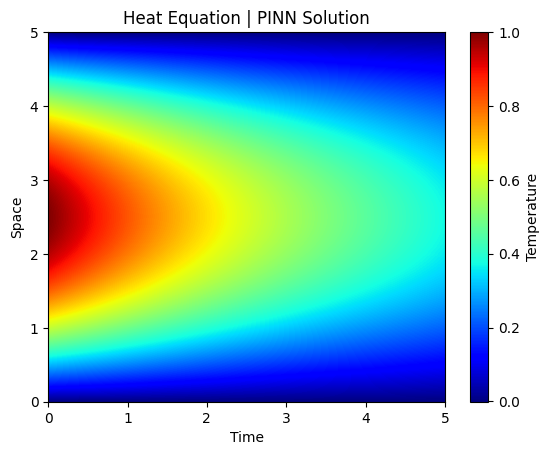

In [1929]:
x_values = jnp.linspace(0, L, int(L/d))
t_values = jnp.linspace(0, T, int(T/d))
x_grid, t_grid = jnp.meshgrid(x_values, t_values, indexing='ij')
heatmap_input_data = jnp.stack([x_grid.ravel(), t_grid.ravel()], axis=-1)


# Predict the solution using the trained model
predictions = jax.lax.map(trained_model, heatmap_input_data)
u_values = predictions.reshape((int(L/d), int(T/d)))

# Plot the heatmap
#plt.figure(figsize=(10, 6))
plt.imshow(u_values, extent=[0, T, 0, L], origin='lower', aspect='auto', cmap='jet')
plt.colorbar(label='Temperature')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Heat Equation | PINN Solution')
plt.show()

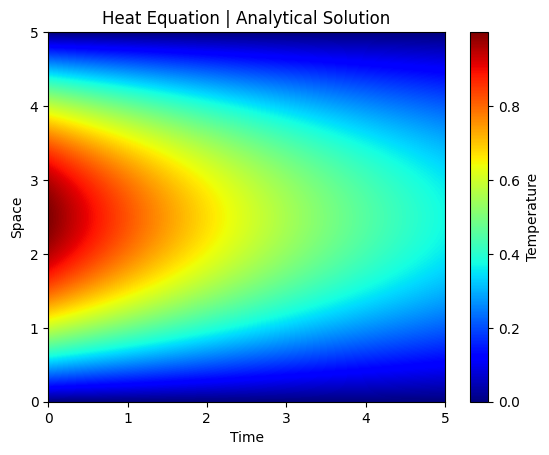

In [1930]:
rod.plot()

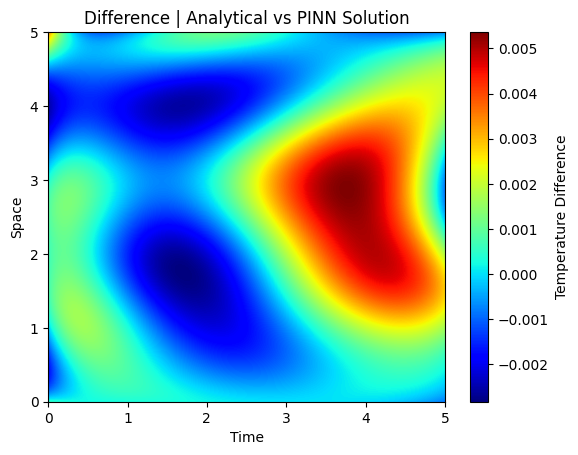

MSE: 4.4030443859810475e-06


In [1934]:
diff = (u_values-rod.solution.T)

plt.imshow(diff, extent=[0, T, 0, L], origin='lower', aspect='auto', cmap='jet')
plt.colorbar(label='Temperature Difference')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Difference | Analytical vs PINN Solution')
plt.show()

print(f'MSE: {np.mean(diff**2)}')

In [1101]:
from scipy.stats import norm

In [1165]:

class BSM():
    ## Class representing the rod

    def __init__(self,  vol, r, S_lim, t_lim):
        self.vol = vol
        self.r = r
        self.S_lim = S_lim
        self.t_lim = t_lim

    def call(self, S, t, K):
        
        d1 = (np.log(S/K) + (self.r + 0.5* self.vol**2)*t)/(self.vol*np.sqrt(t))
        d2 = d1 - self.vol*np.sqrt(t)

        return S*norm.cdf(d1) - np.exp(self.r * t) * K *norm.cdf(d2)


    def solve(self, K, d = 0.01):
        self.K = K
        S_values = np.linspace(9, self.S_lim, int(self.S_lim/d))
        t_values = np.linspace(self.t_lim, 0.01, int(self.t_lim/d))

        self.S_array, self.t_array = np.meshgrid(S_values, t_values)
        
        self.solution = self.call(self.S_array, self.t_array, K)
    
    def plot(self):
        if not hasattr(self, 'solution'):
            print("Solve first")
        else:

            #plt.figure(figsize=(10, 8))
            #plt.contourf(self.x_array, self.t_array, self.solution, levels=15, cmap='hot')
            plt.imshow(self.solution.T, extent=[self.t_lim, 0.01, 9, self.S_lim,], aspect='auto', origin='lower', cmap='jet')
            plt.colorbar(label='Price')
            plt.xlabel('Time to Maturity')
            plt.ylabel('Spot')
            plt.title(f'Call K={self.K}  | Analytical Solution')
            plt.show()



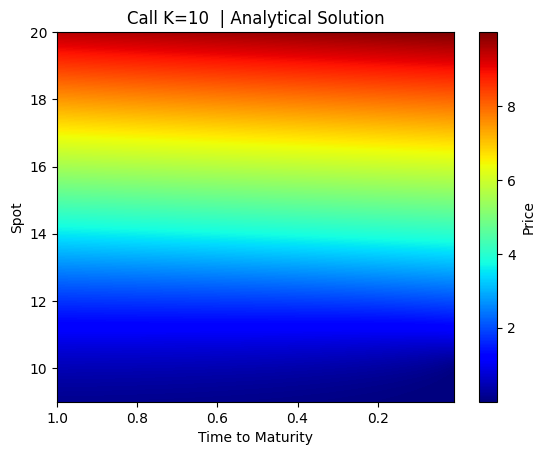

In [1166]:
option = BSM(0.2, 0.05, 20, 1)
option.solve(10)
option.plot()

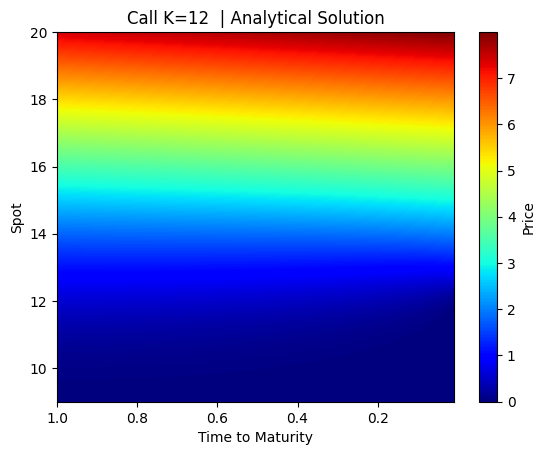

In [1167]:
option = BSM(0.2, 0.05, 20, 1)
option.solve(12)
option.plot()

In [1726]:
# Define model
# Strike always 1
# input = (Spot, time to maturity, vol, risk free rate)
model_key = jax.random.PRNGKey(7)
model_bsm = eqx.nn.MLP(in_size=4, out_size=1, width_size=40, depth=3,
                   activation=jax.nn.tanh, use_final_bias=False, key=model_key)

In [1727]:
# Define the ranges for each element in the sample
spot_range = [0, 2]
#strike_range = [0, 3]
ttm_range = [0.01, 1]
vol_range = [0.01, 0.4]
r_range = [0, 0.2]


# Number of samples to generate
num_samples = 20

# Random key for sampling
key = jax.random.PRNGKey(0)

# Generate samples for each dimension
spot_samples = jax.random.uniform(key, shape=(num_samples, 1), minval=spot_range[0], maxval=spot_range[1])
strike_samples = jax.random.uniform(key, shape=(num_samples, 1), minval=strike_range[0], maxval=strike_range[1])
ttm_samples = jax.random.uniform(key, shape=(num_samples, 1), minval=ttm_range[0], maxval=ttm_range[1])
vol_samples = jax.random.uniform(key, shape=(num_samples, 1), minval=vol_range[0], maxval=vol_range[1])
r_samples = jax.random.uniform(key, shape=(num_samples, 1), minval=r_range[0], maxval=r_range[1])


# Concatenate the samples along the last dimension to form the batch
batch_samples = jnp.concatenate([spot_samples, strike_samples, ttm_samples, vol_samples, r_samples], axis=-1)

In [1728]:
def generate_samples(key, num_samples, spot_range, ttm_range, vol_range, r_range):
    ranges = [spot_range, ttm_range, vol_range, r_range]
    samples = []
    
    for param_range in ranges:
        key, subkey = jax.random.split(key)
        sample = jax.random.uniform(subkey, shape=(num_samples, 1), minval=param_range[0], maxval=param_range[1])
        samples.append(sample)
    
    # Concatenate the samples along the last dimension to form the batch
    batch_samples = jnp.concatenate(samples, axis=-1)
    return batch_samples

In [1729]:
batch_samples = generate_samples(key, num_samples, spot_range, ttm_range, vol_range, r_range)

In [1730]:
batch_samples

Array([[1.3969245 , 0.22025213, 0.2511714 , 0.01581249],
       [0.78449106, 0.18421781, 0.0272165 , 0.05552962],
       [1.244636  , 0.23696454, 0.0273496 , 0.14769486],
       [1.5347445 , 0.3793844 , 0.36419398, 0.0640358 ],
       [1.9546916 , 0.71594524, 0.1640944 , 0.02397811],
       [1.3778255 , 0.9355253 , 0.06423113, 0.14814861],
       [1.3489497 , 0.39585087, 0.2998862 , 0.07852321],
       [1.6235051 , 0.8385212 , 0.37179253, 0.03477776],
       [1.0005488 , 0.1169047 , 0.29273936, 0.0983298 ],
       [0.46384478, 0.5423692 , 0.25821942, 0.01425321],
       [1.5952265 , 0.09929641, 0.24426195, 0.06701034],
       [0.59866285, 0.7701909 , 0.2743964 , 0.04122627],
       [0.7339566 , 0.15908358, 0.39329863, 0.19604965],
       [0.66969967, 0.04564556, 0.03268284, 0.13367248],
       [1.495789  , 0.9549938 , 0.03479649, 0.06672616],
       [0.25594997, 0.81927943, 0.15065734, 0.04568725],
       [0.75994873, 0.7503899 , 0.08511968, 0.12736093],
       [0.05494332, 0.03997967,

In [1731]:
jax.vmap(model_bsm)(batch_samples)

Array([[0.20299216],
       [0.23471162],
       [0.2250242 ],
       [0.20176694],
       [0.19606507],
       [0.23681042],
       [0.21320064],
       [0.20496878],
       [0.21979845],
       [0.24928729],
       [0.19524866],
       [0.2520374 ],
       [0.2357504 ],
       [0.23852637],
       [0.22712688],
       [0.26909325],
       [0.2580228 ],
       [0.24894568],
       [0.27318066],
       [0.20062491]], dtype=float32)

In [1732]:
def pde_loss(params, model_state, x):
    model = eqx.combine(params, model_state)
    
    # Renamed the x in the lambda to single_x to make it more clear
    dv_dt = jax.vmap(lambda single_x: jax.grad(lambda x: model(x)[0])(single_x)[1])(x)
    rs_dv_ds = jax.vmap(lambda single_x: single_x[4] * single_x[0] * jax.grad(lambda x: model(x)[0])(single_x)[0])(x)
    d2v_ds2 = jax.vmap(lambda single_x: 0.5 * single_x[3]**2 * single_x[0]**2 * 
                       jax.grad(lambda x: jax.grad(lambda x: model(x)[0])(x)[0])(single_x)[0])(x)
    rv = jax.vmap(lambda single_x: single_x[4] * model(single_x)[0])(x)

    return jnp.mean((dv_dt + d2v_ds2 + rs_dv_ds - rv)**2)


def fc_loss(params, model_state, x):
    strike = 1
    model = eqx.combine(params, model_state)
    x_update = x.at[:,2].set(0.0) # Set time to maturity as 0
    payoff_dif = jax.vmap(lambda single_x: ((model(single_x)[0] - (jnp.maximum(single_x[0] - strike, 0))))**2)(x_update)
    #model_payoff = jax.vmap(lambda single_x: model(single_x)[0])(x_update)

    return jnp.mean(payoff_dif)

# def bc_loss(params, model_state, x):
#     model = eqx.combine(params, model_state)
#     x_at0 = x.at[:,0].set(0.0) # Set Spot as 0. As Spot -> 0, Call -> 0
#     error_at0 = jax.vmap(lambda single_x: model(single_x)[0]**2)(x_at0)

#     x_atLargeS = x.at[:, 0].set(50.0 * strike)
#     dV_dS_atLargeS = jax.vmap(lambda single_x: jax.grad(lambda x: model(x)[0])(single_x)[0])(x_atLargeS)
#     error_atLargeS = jax.vmap(lambda single_x: dV_dS_atLargeS ** 2)(x_atLargeS)
    
#     return jnp.mean(error_at0) + jnp.mean(error_atLargeS)


def bc_loss(params, model_state, x):
    model = eqx.combine(params, model_state)
    strike = 1
    
    # As Spot -> 0, Call -> 0
    x_at0 = x.at[:, 0].set(0.0)
    error_at0 = jax.vmap(lambda single_x: model(single_x)[0]**2)(x_at0)
    
    # As Spot -> infinity, Call -> S - K * exp(-r * (T - t))
    x_atLargeS = x.at[:, 0].set(50.0 * strike)
    time_to_maturity = x_atLargeS[:, 2]
    #K = x_atLargeS[:, 1]
    r = x_atLargeS[:, 4]
    intrinsic_value_atLargeS = 50.0 * strike - strike * jnp.exp(-r * time_to_maturity)
    model_value_atLargeS = jax.vmap(lambda single_x: model(single_x)[0])(x_atLargeS)
    error_atLargeS = jax.vmap(lambda model_val, intrinsic_val: (model_val - intrinsic_val)**2)(model_value_atLargeS, intrinsic_value_atLargeS)
    
    return jnp.mean(error_at0) + jnp.mean(error_atLargeS)


def loss(params, model_state, x):
    return pde_loss(params, model_state, x) + fc_loss(params, model_state, x) + bc_loss(params, model_state, x)

In [1733]:
params = eqx.filter(model_bsm, eqx.is_array)
model_state = eqx.filter(model_bsm, eqx.is_inexact_array, inverse=True)

In [1734]:
pde_loss(params, model_state, batch_samples)

Array(0.00025597, dtype=float32)

In [1735]:
fc_loss(params, model_state, batch_samples)

Array(0.09142671, dtype=float32)

In [1736]:
bc_loss(params, model_state, batch_samples)

Array(2393.445, dtype=float32)

In [1737]:
batch_samples

Array([[1.3969245 , 0.22025213, 0.2511714 , 0.01581249],
       [0.78449106, 0.18421781, 0.0272165 , 0.05552962],
       [1.244636  , 0.23696454, 0.0273496 , 0.14769486],
       [1.5347445 , 0.3793844 , 0.36419398, 0.0640358 ],
       [1.9546916 , 0.71594524, 0.1640944 , 0.02397811],
       [1.3778255 , 0.9355253 , 0.06423113, 0.14814861],
       [1.3489497 , 0.39585087, 0.2998862 , 0.07852321],
       [1.6235051 , 0.8385212 , 0.37179253, 0.03477776],
       [1.0005488 , 0.1169047 , 0.29273936, 0.0983298 ],
       [0.46384478, 0.5423692 , 0.25821942, 0.01425321],
       [1.5952265 , 0.09929641, 0.24426195, 0.06701034],
       [0.59866285, 0.7701909 , 0.2743964 , 0.04122627],
       [0.7339566 , 0.15908358, 0.39329863, 0.19604965],
       [0.66969967, 0.04564556, 0.03268284, 0.13367248],
       [1.495789  , 0.9549938 , 0.03479649, 0.06672616],
       [0.25594997, 0.81927943, 0.15065734, 0.04568725],
       [0.75994873, 0.7503899 , 0.08511968, 0.12736093],
       [0.05494332, 0.03997967,

In [1738]:
bc_loss(params, model_state, batch_samples)

Array(2393.445, dtype=float32)

In [1739]:
def generate_uniform_samples(num_samples_per_dim, spot_range, ttm_range, vol_range, r_range):
    spot_samples = jnp.linspace(spot_range[0], spot_range[1], num_samples_per_dim)
    ttm_samples = jnp.linspace(ttm_range[0], ttm_range[1], num_samples_per_dim)
    vol_samples = jnp.linspace(vol_range[0], vol_range[1], num_samples_per_dim)
    r_samples = jnp.linspace(r_range[0], r_range[1], num_samples_per_dim)
    
    # Create a meshgrid to cover the space uniformly
    spot_grid, ttm_grid, vol_grid, r_grid = jnp.meshgrid(
        spot_samples, ttm_samples, vol_samples, r_samples, indexing='ij'
    )
    
    # Flatten the grids and stack them into samples
    batch_samples = jnp.stack([spot_grid.ravel(), ttm_grid.ravel(), vol_grid.ravel(), r_grid.ravel()], axis=-1)
    
    return batch_samples

In [1740]:
from scipy.stats import qmc

def generate_latin_hypercube_samples(num_samples, spot_range, ttm_range, vol_range, r_range):
    # Define the ranges for each parameter
    parameter_ranges = jnp.array([spot_range, ttm_range, vol_range, r_range])
    
    # Create a Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=len(parameter_ranges))
    
    # Sample points in the unit hypercube
    sample_points = sampler.random(n=num_samples)
    
    # Scale the points to the desired parameter ranges
    scaled_samples = qmc.scale(sample_points, parameter_ranges[:, 0], parameter_ranges[:, 1])
    
    return jnp.array(scaled_samples)

In [1741]:
batch_samples = generate_uniform_samples(4, spot_range, ttm_range, vol_range, r_range)

In [1742]:
batch_samples = generate_latin_hypercube_samples(4, spot_range, ttm_range, vol_range, r_range)

In [1743]:
batch_samples

Array([[0.2837624 , 0.25096953, 0.35986042, 0.0662553 ],
       [1.5472224 , 0.78913856, 0.0645564 , 0.10219695],
       [1.3721726 , 0.57278275, 0.11257681, 0.0167637 ],
       [0.9861157 , 0.45690396, 0.24656999, 0.18869457]], dtype=float32)

In [1744]:
fc_loss(params, model_state, batch_samples)

Array(0.06323437, dtype=float32)

In [1745]:
# Training parameters
num_epochs = 10000

# Learning rate
lr = 0.0001

num_samples = 100

# Parameters for exponential decay
decay_steps = num_epochs/100
decay_rate = 0.99
staircase = True

# Create the learning rate schedule
schedule = optax.exponential_decay(
    init_value=lr,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=staircase)


# Optimizer definition
params = eqx.filter(model_bsm, eqx.is_array)
model_state = eqx.filter(model_bsm, eqx.is_inexact_array, inverse=True)
optimizer = optax.adam(learning_rate=schedule)
opt_state = optimizer.init(params)



# Define the function to perform a single training step
@eqx.filter_jit
def train_step(params, model_state, opt_state, x):
    loss_value, grads = jax.value_and_grad(loss)(params, model_state, x)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

# Training loop
for epoch in range(num_epochs):
    
    #key = jax.random.PRNGKey(epoch)
    #batch_samples = generate_samples(key, num_samples, spot_range, strike_range, ttm_range, vol_range, r_range)
    batch_samples = generate_latin_hypercube_samples(100, spot_range, ttm_range, vol_range, r_range)

    params, opt_state, loss_value = train_step(params, model_state, opt_state, batch_samples)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_value}")

    # if epoch % 1000 == 0:
    #     lr *= 0.5
    #     optimizer = optax.adam(learning_rate=lr)
    #     opt_state = optimizer.init(params)  # Re-initialize optimizer state with new learning rate

# Print final loss
final_loss = loss(params, model_state, batch_samples)
print(f"Final Loss: {final_loss}")

Epoch 0, Loss: 2394.15869140625
Epoch 100, Loss: 2290.953369140625
Epoch 200, Loss: 2172.02001953125
Epoch 300, Loss: 2079.349609375
Epoch 400, Loss: 2010.6168212890625
Epoch 500, Loss: 1955.4923095703125
Epoch 600, Loss: 1908.916748046875
Epoch 700, Loss: 1867.1500244140625
Epoch 800, Loss: 1828.705078125
Epoch 900, Loss: 1792.449951171875
Epoch 1000, Loss: 1757.9517822265625
Epoch 1100, Loss: 1724.700927734375
Epoch 1200, Loss: 1692.62548828125
Epoch 1300, Loss: 1661.6693115234375
Epoch 1400, Loss: 1631.8192138671875
Epoch 1500, Loss: 1602.6273193359375
Epoch 1600, Loss: 1574.4716796875
Epoch 1700, Loss: 1547.0416259765625
Epoch 1800, Loss: 1520.5177001953125
Epoch 1900, Loss: 1494.42919921875
Epoch 2000, Loss: 1469.209716796875
Epoch 2100, Loss: 1444.424560546875
Epoch 2200, Loss: 1420.4256591796875
Epoch 2300, Loss: 1396.8228759765625
Epoch 2400, Loss: 1373.7662353515625
Epoch 2500, Loss: 1351.2352294921875
Epoch 2600, Loss: 1329.2359619140625
Epoch 2700, Loss: 1307.6298828125
Epoc

In [1699]:
trained_model_bsm = eqx.combine(params, model_state)

In [1700]:
key = jax.random.PRNGKey(9843)
batch_samples = generate_samples(key, 5, spot_range, ttm_range, vol_range, r_range)

In [1701]:
# input = (Spot, time to maturity, vol, risk free rate)

In [1702]:
batch_samples

Array([[0.23112369, 0.2325075 , 0.30971462, 0.17253338],
       [0.8721745 , 0.64452386, 0.2659205 , 0.15121253],
       [1.1148195 , 0.20968676, 0.14905287, 0.09452837],
       [1.3098707 , 0.42822993, 0.15519549, 0.16802953],
       [1.3933401 , 0.96386033, 0.09833441, 0.10316908]], dtype=float32)

In [1703]:
jax.vmap(trained_model_bsm)(batch_samples)

Array([[0.02552449],
       [0.39885822],
       [0.37194276],
       [0.56655973],
       [0.5236599 ]], dtype=float32)

In [1496]:
prices = [0.0102, 0.4565, ]

In [1705]:
0.2659205   *365

97.0609825

In [1498]:
trained_model_bsm(jnp.array([5, 10, 0, 3.4644008e-01,
        8.1193447e-03]))

Array([3.020972], dtype=float32)